In [4]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
# from dataset_factory import *
# from coco_dataset import *
from file_utils import *
from tqdm import tqdm

In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
config_data = read_file_in_dir('./', "task-1-default-config" + '.json')

In [5]:
config_data['dataset']

{'training_ids_file_path': './train_ids.csv',
 'validation_ids_file_path': './val_ids.csv',
 'test_ids_file_path': './test_ids.csv',
 'training_annotation_file_path': './data/annotations/captions_train2014.json',
 'test_annotation_file_path': './data/annotations/captions_val2014.json',
 'images_root_dir': './data/images/',
 'vocabulary_threshold': 2,
 'img_size': 256,
 'batch_size': 64,
 'num_workers': 0}

In [6]:
coco, coco_test, vocabulary, train_data_loader, val_data_loader, test_data_loader =  get_datasets(config_data)

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
Using the saved vocab.
loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
loading annotations into memory...
Done (t=0.75s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [7]:
coco

In [8]:
for i in enumerate(tqdm(train_data_loader)):
    test=i[1]
    break

  0%|          | 0/1165 [00:04<?, ?it/s]


In [9]:
len(test)

3

In [10]:
test[0].shape

torch.Size([64, 3, 256, 256])

In [11]:
convd = nn.Conv2d(3,64,kernel_size = 11,stride = 4)

In [12]:
import matplotlib.pyplot as plt

In [13]:
image =test[0][1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


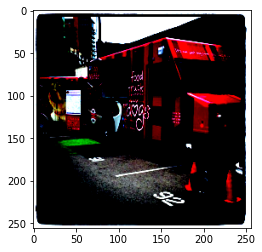

In [14]:
plt.imshow(image.numpy().squeeze().transpose(1,2,0))

In [15]:
test[1][0]

tensor([   1,   79,  123,   14,   49,  331, 1610,  164,    4,   29,   22,   52,
         146,  336, 3472,  330,    4,  172,   88,  178,   79,   62,   88,   79,
           4,   62, 1671,  365,  890,  179,  657, 9131,    4,   61, 1615, 3603,
          19,    2])

In [16]:
image_batch = test[0] # batchsize, 3, 256, 256
caption_batch = test[1] # batchsize, 22

In [65]:
conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4)
batch_norm1 = nn.BatchNorm2d(num_features=64)
pool1 = nn.MaxPool2d(kernel_size=3,stride=2)
conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,padding=2)
batch_norm2 = nn.BatchNorm2d(num_features=128)
pool2 = nn.MaxPool2d(kernel_size=3,stride=2)
conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
batch_norm3 = nn.BatchNorm2d(num_features=256)
conv4 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
batch_norm4 = nn.BatchNorm2d(num_features=256)
conv5 = nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,padding=1)
batch_norm5 = nn.BatchNorm2d(num_features=128)
pool3 = nn.AdaptiveAvgPool2d((1,1))
fc1 = nn.Linear(in_features=128,out_features=1024)
fc2 = nn.Linear(in_features=1024,out_features=1024)
fc3 = nn.Linear(in_features=1024,out_features=14463)

In [85]:
out = F.relu(batch_norm1(conv1(image_batch)))
print(out.shape)
out = pool1(out)
print(out.shape)
out = F.relu(batch_norm2(conv2(out)))
out = pool2(out)
print(out.shape)
out = F.relu(batch_norm3(conv3(out)))
print(out.shape)
out = F.relu(batch_norm4(conv4(out)))
print(out.shape)
out = F.relu(batch_norm5(conv5(out)))
print(out.shape)
out = pool2(out)
print(out.shape)
out = pool3(out)
out = out.squeeze()
print(out.shape)
out = F.relu(fc1(out))
print(out.shape)
out = F.relu(fc2(out))
print(out.shape)
out = F.relu(fc3(out))
print(out.shape)

torch.Size([64, 64, 62, 62])
torch.Size([64, 64, 30, 30])
torch.Size([64, 128, 14, 14])
torch.Size([64, 256, 14, 14])
torch.Size([64, 256, 14, 14])
torch.Size([64, 128, 14, 14])
torch.Size([64, 128, 6, 6])
torch.Size([64, 128])
torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 14463])


In [86]:
captions_batch = test[1]
captions_batch.shape

torch.Size([64, 38])

In [96]:
fc = nn.Linear(in_features = 14463,out_features = 300)
embedding = nn.Embedding(num_embeddings=14463,embedding_dim=300)
model = nn.LSTM(input_size = 300,num_layers = 2, hidden_size = 512, batch_first = True)
outlayer = nn.Linear(in_features=512,out_features=14463)
softmax = nn.Softmax(dim=2)

In [88]:
captions_batch.shape

torch.Size([64, 38])

In [89]:
out.shape

torch.Size([64, 14463])

In [90]:
out = fc(out)
out.shape

torch.Size([64, 300])

In [91]:
embeded_captions = embedding(captions_batch[:,:-1])
embeded_captions.shape

torch.Size([64, 37, 300])

In [92]:
test_out = out.unsqueeze(1)
test_out.shape

torch.Size([64, 1, 300])

In [93]:
test_in = torch.cat((test_out, embeded_captions),dim=1)
test_in.shape

torch.Size([64, 38, 300])

In [94]:
LSTM_out, (hn,cn) = model(test_in)
LSTM_out.shape

torch.Size([64, 38, 512])

In [98]:
temp = 0.4
LSTM_out = LSTM_out/temp
LSTM_out= softmax(outlayer(LSTM_out))

LSTM_out.shape

torch.Size([64, 38, 14463])

In [101]:
torch.sum(LSTM_out[0][0])

tensor(1., grad_fn=<SumBackward0>)

In [ ]:
for i in test[1][0]:
    print(vocabulary.idx2word[i.item()])

In [ ]:
vocabulary.idx2word

In [ ]:
np.argmax(F.one_hot(captions_batch)[0],axis=1)

In [ ]:
captions_batch[0]

In [11]:
from torchvision.models import resnet50
model = resnet50(pretrained=True)
print(model)
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
print(newmodel)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 